In [ ]:
print("hey")

hello


In [20]:
import sys
sys.path.append('/home/dylan-kmutt/ubpd')

In [21]:
from src.helper import get_train_test_pids

train_v_pids, test_pids = get_train_test_pids("../../data/dataset/images/", seed=42)
all_pids = train_v_pids + test_pids
len(all_pids)

88

In [22]:
from typing import List, Tuple
import random
import math

def split_train_and_test(pids: List[int], seed: int = 42) -> Tuple[List[int], List[int]]:
    if not pids:
        return [], []

    # De-duplicate while preserving order
    unique = list(dict.fromkeys(pids))
    n = len(unique)

    # Reproducible shuffle
    rng = random.Random(seed)
    idxs = list(range(n))
    rng.shuffle(idxs)
    shuffled = [unique[i] for i in idxs]

    # Compute test size (≈15%); keep at least 1 test if possible, and at least 1 train
    raw_test = int(round(n * 0.15))
    if n >= 2:
        test_size = max(1, min(raw_test, n - 1))
    else:
        test_size = 0  # only one item → all train

    test_ids = shuffled[:test_size]
    train_ids = shuffled[test_size:]

    return train_ids, test_ids


In [23]:
ultrasound_1_pids = [i for i in range(7, 44+1) if i in all_pids]

sub_1_ultrasound_2_pids = [i for i in range(47, 166+1) if i in all_pids]
sub_2_ultrasound_2_pids = [i for i in range(1, 6+1) if i in all_pids]
ultrasound_2_pids = sub_1_ultrasound_2_pids + sub_2_ultrasound_2_pids

print(f"# Patients in Ultrasound 1: {len(ultrasound_1_pids)}")
print(f"# Patients in Ultrasound 2: {len(ultrasound_2_pids)}")

# Patients in Ultrasound 1: 36
# Patients in Ultrasound 2: 52


In [25]:
seed = 94
u1_train_pids, u1_test_pids = split_train_and_test(ultrasound_1_pids, seed=seed)
u2_train_pids, u2_test_pids = split_train_and_test(ultrasound_2_pids, seed=seed)

# Combine (concat) and deduplicate while keeping order
comb_train_pids = list(dict.fromkeys(list(u1_train_pids) + list(u2_train_pids)))
comb_test_pids  = list(dict.fromkeys(list(u1_test_pids)  + list(u2_test_pids)))

# Optional: ensure no leakage between train/test
leak = set(comb_train_pids) & set(comb_test_pids)
if leak:
    comb_train_pids = [p for p in comb_train_pids if p not in leak]
    print("leak")
    # or raise an error/log, depending on your policy

print(f"Seed: {seed}\n")
print(f"Ultrasound 1: train {len(u1_train_pids)} pids, test {len(u1_test_pids)} pids")
print(f"  Train PIDs: {', '.join(map(str, u1_train_pids))}")
print(f"  Test  PIDs: {', '.join(map(str, u1_test_pids))}\n")

print(f"Ultrasound 2: train {len(u2_train_pids)} pids, test {len(u2_test_pids)} pids")
print(f"  Train PIDs: {', '.join(map(str, u2_train_pids))}")
print(f"  Test  PIDs: {', '.join(map(str, u2_test_pids))}\n")

print(f"Combined: train {len(comb_train_pids)} pids, test {len(comb_test_pids)} pids")
print(f"  Train PIDs: {', '.join(map(str, comb_train_pids))}")
print(f"  Test  PIDs: {', '.join(map(str, comb_test_pids))}")

Seed: 94

Ultrasound 1: train 31 pids, test 5 pids
  Train PIDs: 19, 38, 23, 13, 28, 17, 10, 12, 42, 21, 34, 25, 30, 31, 37, 41, 15, 40, 39, 16, 44, 22, 29, 7, 36, 20, 27, 24, 14, 18, 43
  Test  PIDs: 11, 35, 32, 9, 8

Ultrasound 2: train 44 pids, test 8 pids
  Train PIDs: 93, 85, 83, 88, 64, 131, 78, 87, 67, 61, 49, 51, 60, 52, 73, 66, 65, 92, 99, 75, 53, 79, 5, 84, 76, 90, 47, 97, 166, 6, 3, 94, 1, 2, 77, 86, 100, 48, 82, 71, 69, 58, 63, 89
  Test  PIDs: 50, 62, 98, 4, 81, 96, 70, 68

Combined: train 75 pids, test 13 pids
  Train PIDs: 19, 38, 23, 13, 28, 17, 10, 12, 42, 21, 34, 25, 30, 31, 37, 41, 15, 40, 39, 16, 44, 22, 29, 7, 36, 20, 27, 24, 14, 18, 43, 93, 85, 83, 88, 64, 131, 78, 87, 67, 61, 49, 51, 60, 52, 73, 66, 65, 92, 99, 75, 53, 79, 5, 84, 76, 90, 47, 97, 166, 6, 3, 94, 1, 2, 77, 86, 100, 48, 82, 71, 69, 58, 63, 89
  Test  PIDs: 11, 35, 32, 9, 8, 50, 62, 98, 4, 81, 96, 70, 68


In [26]:
def report_leak(tag, train_ids, test_ids):
    leak = set(train_ids) & set(test_ids)
    if leak:
        print(f"[LEAK] {tag}: {len(leak)} overlapping PID(s): {', '.join(map(str, sorted(leak)))}")
    else:
        print(f"[OK]   {tag}: no leakage.")

# Per-dataset leakage
report_leak("Ultrasound 1", u1_train_pids, u1_test_pids)
report_leak("Ultrasound 2", u2_train_pids, u2_test_pids)

# Cross-dataset leakage (train of one vs test of the other)
report_leak("U1 train vs U2 test", u1_train_pids, u2_test_pids)
report_leak("U2 train vs U1 test", u2_train_pids, u1_test_pids)

# Combined leakage
report_leak("Combined", comb_train_pids, comb_test_pids)

[OK]   Ultrasound 1: no leakage.
[OK]   Ultrasound 2: no leakage.
[OK]   U1 train vs U2 test: no leakage.
[OK]   U2 train vs U1 test: no leakage.
[OK]   Combined: no leakage.


In [27]:
from src.helper import get_cv_pids

u1_cv_pids = get_cv_pids(u1_train_pids, cv=5)
u2_cv_pids = get_cv_pids(u2_train_pids, cv=5)

In [28]:
assert len(u1_cv_pids) == len(u2_cv_pids), "U1 and U2 must have the same # of folds"

comb_cv_pids: list[tuple[list[int], list[int]]] = []
for (u1_tr, u1_val), (u2_tr, u2_val) in zip(u1_cv_pids, u2_cv_pids):
    # concat + dedup while keeping order
    comb_tr  = list(dict.fromkeys(list(u1_tr)  + list(u2_tr)))
    comb_val = list(dict.fromkeys(list(u1_val) + list(u2_val)))

    # optional: sanity check for leakage within the fold
    leak = set(comb_tr) & set(comb_val)
    if leak:
        print(f"[LEAK] Combined fold has overlap: {sorted(leak)}")

    comb_cv_pids.append((comb_tr, comb_val))


In [29]:
def print_cv(name: str, cv_pids: list[tuple[list[int], list[int]]]) -> None:
    print(f"{name}: {len(cv_pids)} folds")
    for i, (train, val) in enumerate(cv_pids, start=1):
        print(f" Fold {i}: train {len(train)} pids, val {len(val)} pids")
        print(f"   Train: {', '.join(map(str, train))}")
        print(f"   Val  : {', '.join(map(str, val))}")
        leak = set(train) & set(val)
        if leak:
            print(f"   [LEAK] {len(leak)} overlapping PID(s): {', '.join(map(str, sorted(leak)))}")
    print()

print_cv("Ultrasound 1 (CV)", u1_cv_pids)
print_cv("Ultrasound 2 (CV)", u2_cv_pids)
print_cv("Combined (CV)", comb_cv_pids)


Ultrasound 1 (CV): 5 folds
 Fold 1: train 25 pids, val 6 pids
   Train: 17, 30, 25, 41, 21, 27, 43, 29, 15, 14, 38, 31, 39, 23, 40, 22, 18, 28, 20, 12, 42, 7, 19, 13, 44
   Val  : 16, 37, 34, 36, 24, 10
 Fold 2: train 25 pids, val 6 pids
   Train: 16, 37, 34, 36, 24, 10, 43, 29, 15, 14, 38, 31, 39, 23, 40, 22, 18, 28, 20, 12, 42, 7, 19, 13, 44
   Val  : 17, 30, 25, 41, 21, 27
 Fold 3: train 25 pids, val 6 pids
   Train: 16, 37, 34, 36, 24, 10, 17, 30, 25, 41, 21, 27, 39, 23, 40, 22, 18, 28, 20, 12, 42, 7, 19, 13, 44
   Val  : 43, 29, 15, 14, 38, 31
 Fold 4: train 25 pids, val 6 pids
   Train: 16, 37, 34, 36, 24, 10, 17, 30, 25, 41, 21, 27, 43, 29, 15, 14, 38, 31, 20, 12, 42, 7, 19, 13, 44
   Val  : 39, 23, 40, 22, 18, 28
 Fold 5: train 24 pids, val 7 pids
   Train: 16, 37, 34, 36, 24, 10, 17, 30, 25, 41, 21, 27, 43, 29, 15, 14, 38, 31, 39, 23, 40, 22, 18, 28
   Val  : 20, 12, 42, 7, 19, 13, 44

Ultrasound 2 (CV): 5 folds
 Fold 1: train 36 pids, val 8 pids
   Train: 64, 86, 84, 51, 3, 7

In [30]:
import numpy as np
import os
import wandb

from src.dataset import UBPDataset
from src.preprocessing import PairedTransform
from src.dataset import UBPDataset
from src.preprocessing import PairedTransform
from src.train import Trainer
from src.evaluate import Evaluator
from src.helper import (
    set_seed,
    _build_model_factory,
    aggregate_fold_metrics,
)

def experiment(variants, exp_id, seed=42):
    # CV
    exp_id = str(exp_id)
    all_histories = []
    fold_overall_means = []
    fold_results = []  # store per-fold evaluator outputs (dicts)

    # exp_id = random.randint(int(1e5), int(1e6) - 1)
    model_name = variants["model"]

    set_seed(seed)
    print(f"\n🚀 Beginning experiment #{exp_id}")
    print("=" * 60)

    include_classes = variants.get("include_classes")
    class_names = {
        1: "dongmai (artery)",
        2: "jingmai (vein)",
        3: "jirouzuzhi (muscle)",
        4: "shenjing (nerve)",
    }
    print("Included classes:")
    for cid in include_classes:
        print(f"  {cid}: {class_names.get(cid, 'unknown')}")
    print(f"\n- Model: {model_name}")
    print(f"- Augment: {variants['augment']}")

    include_classes = variants["include_classes"]
    n_inc = len(include_classes)
    if n_inc == 1:
        variants["loss"] = "bce"
        num_classes_for_model = 1  # single foreground channel
        keep_original_indices = True  # irrelevant when binary
    else:
        variants["loss"] = "ce"
        num_classes_for_model = n_inc + 1  # background + selected classes only
        keep_original_indices = False  # remap selected IDs to contiguous {0..K}
    variants["num_classes"] = num_classes_for_model

    print(
        f"- Using loss='{variants['loss']}' with model num_classes={num_classes_for_model}"
    )
    if not keep_original_indices:
        print(
            "- Remapping labels to contiguous IDs: background=0, selected classes=1..K"
        )
    print(f"- Image size: {variants['image_size']}")
    print("-" * 60)

    if variants["dataset"] == "u1":
        test_pids = u1_test_pids
        cv_pids = u1_cv_pids
    if variants["dataset"] == "u2":
        test_pids = u2_test_pids
        cv_pids = u2_cv_pids
    if variants["dataset"] == "combined":
        test_pids = comb_test_pids
        cv_pids = comb_cv_pids

    paired_train_tf = PairedTransform(size=variants["image_size"], aug=variants["augment"])
    paired_test_tf = PairedTransform(size=variants["image_size"], aug=False)
    test_dataset = UBPDataset(
        p_ids=test_pids,
        include_classes=include_classes,
        image_dir="../../data/dataset/images",
        json_dir="../../data/dataset/labels/json_train",
        joint_transform=paired_test_tf,
        keep_original_indices=True,
    )

    print("Test landmarks stat: ")
    test_dataset.print_stats()
    len(test_dataset)

    for fold in range(1, len(cv_pids)+1):
        name = f"{exp_id}_fold_{fold}"
        if variants["use_wandb"]:
            api_key = os.getenv("WANDB_API_KEY")
            wandb.login(key=api_key)
            wandb.init(
                project="ubpd",
                group=exp_id,
                name=name,
                config=variants,
                reinit=True,
            )
        train_pids, val_pids = cv_pids[fold-1]

        print(f"\n📂 Fold {fold}/{len(cv_pids)}")
        print(f"  Train patient IDs: {train_pids}")
        print(f"  Val   patient IDs: {val_pids}\n")

        train_dataset = UBPDataset(
            p_ids=train_pids,
            include_classes=include_classes,
            image_dir="../../data/dataset/images",
            json_dir="../../data/dataset/labels/json_train",
            joint_transform=paired_train_tf,
            keep_original_indices=keep_original_indices,  # <--- important
        )

        val_dataset = UBPDataset(
            p_ids=val_pids,
            include_classes=include_classes,
            image_dir="../../data/dataset/images",
            json_dir="../../data/dataset/labels/json_train",
            joint_transform=paired_test_tf,
            keep_original_indices=keep_original_indices,  # <--- important
        )

        print("Train landmarks stat: ")
        train_dataset.print_stats()
        print()
        print("Validation landmarks stat:")
        val_dataset.print_stats()
        val_dataset.visualize_image_transform(0)

        make_model = _build_model_factory(model_name)
        model = make_model(num_classes=num_classes_for_model)

        trainer = Trainer(
            exp_id=exp_id,
            fold_num=fold,
            model=model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            arguments=variants,
        )
        history = trainer.train()
        all_histories.append(history)

        if history["val_loss"]:
            best_idx = int(np.argmin(history["val_loss"]))
            print(
                f"  ✅ Best @ epoch {best_idx+1}: val_loss={history['val_loss'][best_idx]:.4f} | val_dice={history['val_dice'][best_idx]:.4f}"
            )
        print("-" * 60)

        # Evaluate one fold (you can move this after the loop to evaluate the final/best model instead)
        evaluator = Evaluator(
            trainer.model,
            test_dataset,
            num_classes=num_classes_for_model,
            ignore_empty_classes=False,
        )
        res = evaluator.evaluate_dice_score(show_plot=True)
        evaluator.visualize_ranked()
                # collect overall mean dice for this fold if available
        try:
            overall_mean = res.get("overall", {}).get("mean", float("nan"))
        except Exception:
            overall_mean = float("nan")
        fold_overall_means.append(
            float(overall_mean) if overall_mean is not None else float("nan")
        )
        fold_results.append(res)

    overall_mean, overall_std, per_class_stats = aggregate_fold_metrics(fold_results)
    if not np.isnan(overall_mean):
        print(
            f"\n🎯 Average overall Dice across folds: {overall_mean:.4f} ± {overall_std:.4f}  (n={len(fold_results)})"
        )
    else:
        print("\n⚠️ No per-fold overall Dice scores collected.")

    # Print per-landmark (per-class) averages
    if per_class_stats:
        print("\n📌 Per-landmark average Dice across folds:")
        for cid in sorted(per_class_stats.keys()):
            stats = per_class_stats[cid]
            name = class_names.get(cid, f"class_{cid}")
            print(
                f"  {cid}: {name:<20s} mean±std: {stats['mean']:.4f} ± {stats['std']:.4f}  (folds={stats['n_folds']})"
            )
    else:
        print("\n⚠️ No per-class stats available to aggregate.")

    print("\n✅ Experiment complete across folds.")

    if variants["use_wandb"]:
        wandb.finish()
        
    return {
        "histories": all_histories,
        "test_dataset": test_dataset,
        "fold_overall_means": fold_overall_means,
    }


In [17]:
import torch

variants = {
    "model": "unet",
    "cv": 5,
    "include_classes": [4],
    "dataset": "combined",

    "epochs": 100,
    "batch_size": 16,
    "num_workers": 2,
    "image_size": 512,
    
    "patience": 20,
    "scheduler": "plateau",
    "plateau_cooldown": 10,
    
    "half_precision": True,
    "ignore_empty": False,
    "augment": True,
    "cuda": "cuda" if torch.cuda.is_available() else "cpu",
    "use_wandb": True,
    "save_dir": "../../checkpoints"
}

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/dylan-kmutt/.netrc



🚀 Beginning experiment #909999
Included classes:
  4: shenjing (nerve)

- Model: unet
- Augment: True
- Using loss='bce' with model num_classes=1
- Image size: 512
------------------------------------------------------------
Test landmarks stat: 
Nerve  present: 137/147 images



📂 Fold 1/5
  Train patient IDs: [17, 30, 25, 41, 21, 27, 43, 29, 15, 14, 38, 31, 39, 23, 40, 22, 18, 28, 20, 12, 42, 7, 19, 13, 44, 64, 86, 84, 51, 3, 79, 60, 90, 48, 82, 166, 52, 76, 53, 5, 6, 89, 93, 75, 65, 63, 100, 1, 58, 83, 97, 131, 77, 78, 67, 73, 66, 92, 85, 87, 69]
  Val   patient IDs: [16, 37, 34, 36, 24, 10, 61, 88, 49, 2, 71, 99, 94, 47]

Train landmarks stat: 
Nerve  present: 631/661 images

Validation landmarks stat:
Nerve  present: 129/147 images


Epoch 001/100 | lr=1.000e-03 train_loss=0.2023 val_loss=0.1025 train_dice=0.0160 val_dice=0.1083 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.0993 val_loss=0.0818 train_dice=0.0298 val_dice=0.1083 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.0811 val_loss=0.0664 train_dice=0.0283 val_dice=0.1396 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.0686 val_loss=0.0616 train_dice=0.0375 val_dice=0.1083 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.0586 val_loss=0.0530 train_dice=0.0400 val_dice=0.1083 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.0513 val_loss=0.0467 train_dice=0.0769 val_dice=0.1176 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.0465 val_loss=0.0504 train_dice=0.2011 val_dice=0.1834  (patience 1/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.0413 val_loss=0.0414 train_dice=0.2923 val_dice=0.2172 [BEST] (patience 0/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.0369

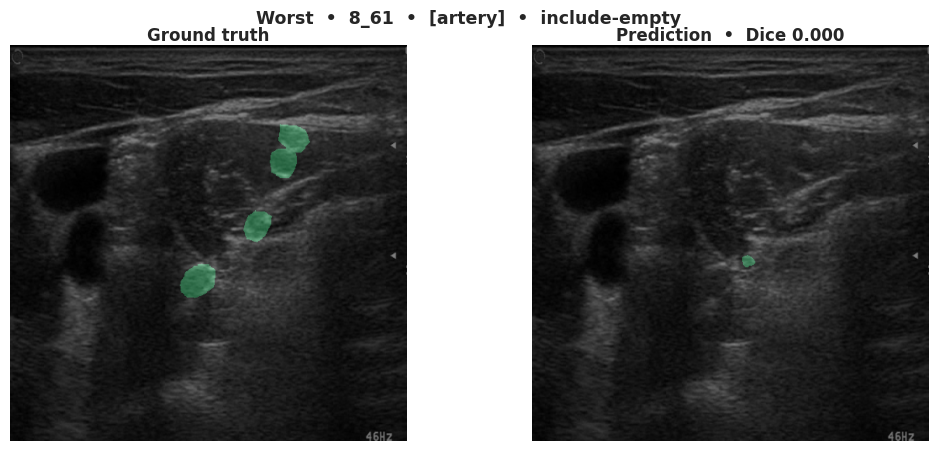

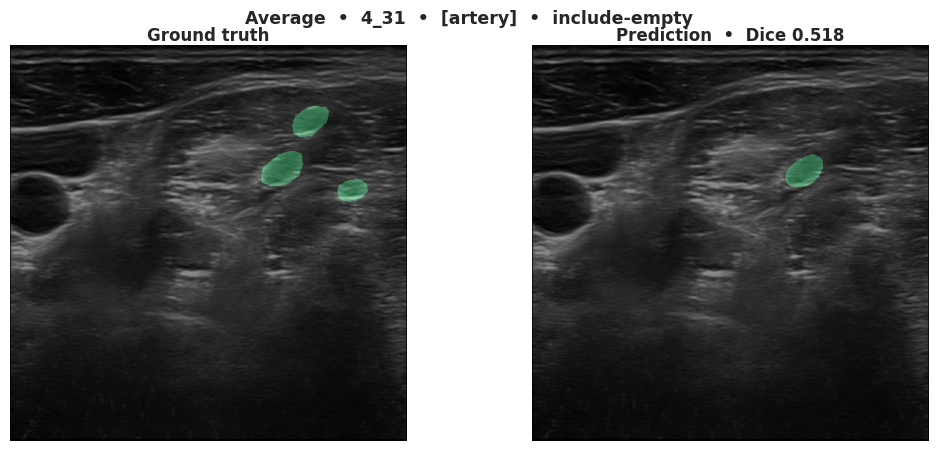

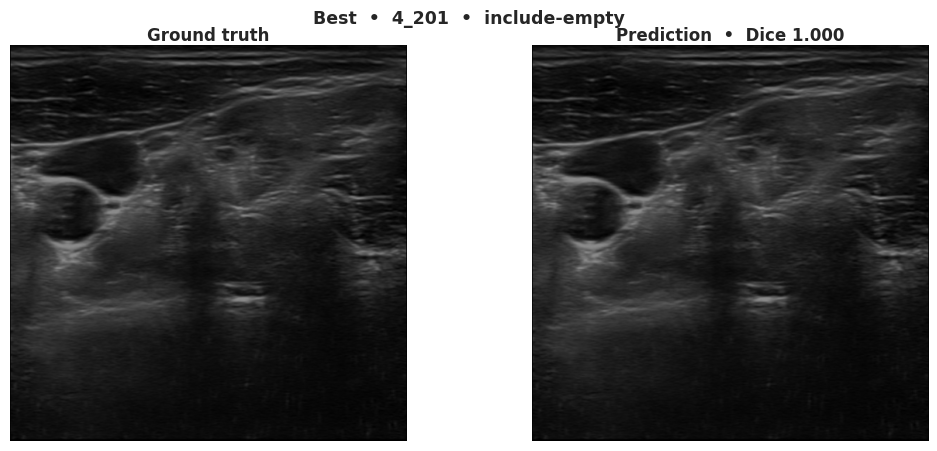

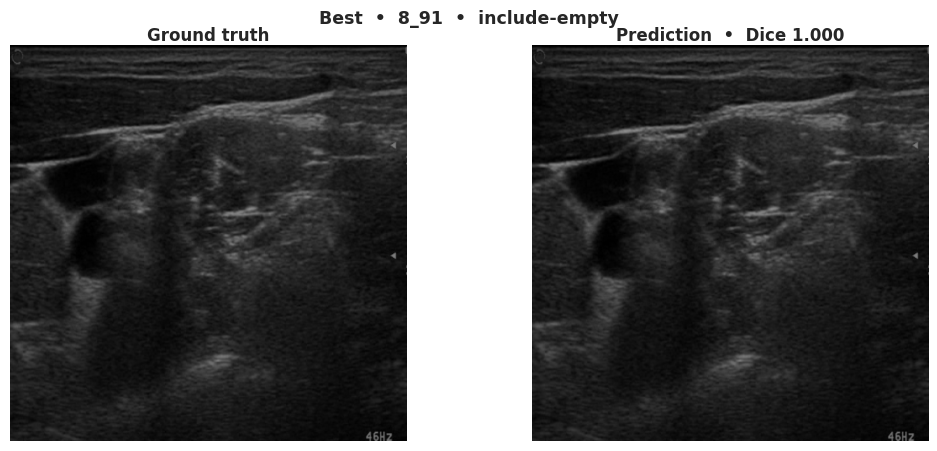

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: ERROR The nbformat package was not found. It is required to save notebook history.



📂 Fold 2/5
  Train patient IDs: [16, 37, 34, 36, 24, 10, 43, 29, 15, 14, 38, 31, 39, 23, 40, 22, 18, 28, 20, 12, 42, 7, 19, 13, 44, 61, 88, 49, 2, 71, 99, 94, 47, 48, 82, 166, 52, 76, 53, 5, 6, 89, 93, 75, 65, 63, 100, 1, 58, 83, 97, 131, 77, 78, 67, 73, 66, 92, 85, 87, 69]
  Val   patient IDs: [17, 30, 25, 41, 21, 27, 64, 86, 84, 51, 3, 79, 60, 90]

Train landmarks stat: 
Nerve  present: 607/647 images

Validation landmarks stat:
Nerve  present: 153/161 images


Epoch 001/100 | lr=1.000e-03 train_loss=0.1971 val_loss=0.1764 train_dice=0.0347 val_dice=0.0042 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.0988 val_loss=0.0978 train_dice=0.0442 val_dice=0.0114 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.0775 val_loss=0.0904 train_dice=0.0551 val_dice=0.1713 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.0648 val_loss=0.0701 train_dice=0.1039 val_dice=0.0774 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.0540 val_loss=0.0627 train_dice=0.2127 val_dice=0.1075 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.0459 val_loss=0.0593 train_dice=0.3198 val_dice=0.1684 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.0399 val_loss=0.0527 train_dice=0.3940 val_dice=0.3633 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.0350 val_loss=0.0504 train_dice=0.4391 val_dice=0.3126 [BEST] (patience 0/20)
Epoch 009/100 | lr=1.000e-03 train_loss=

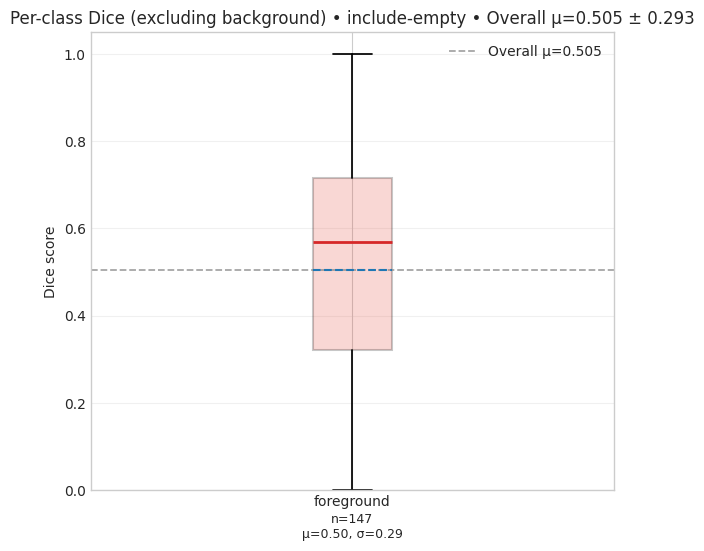

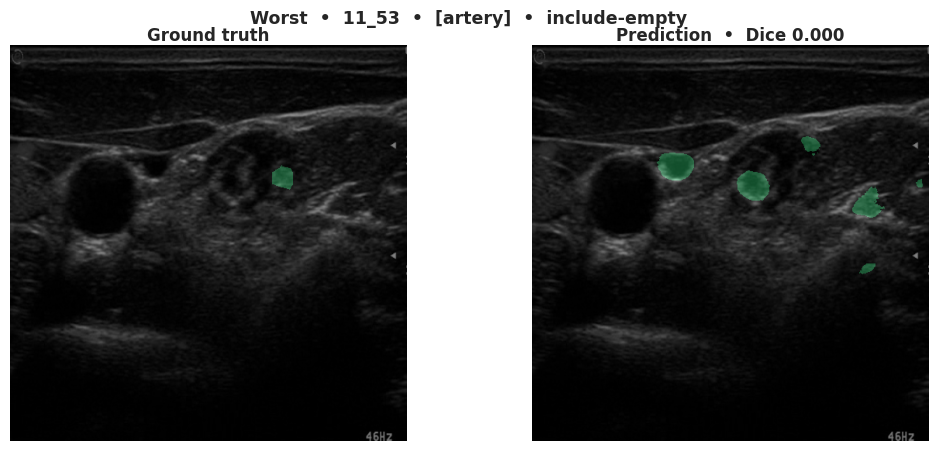

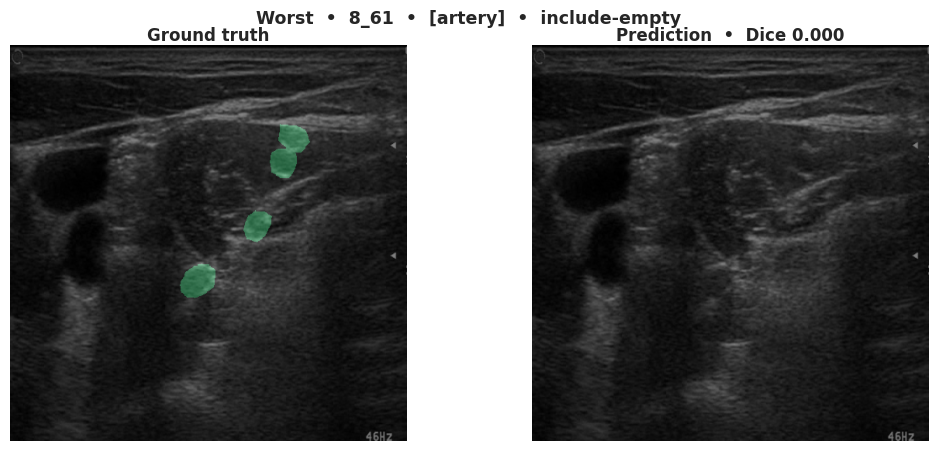

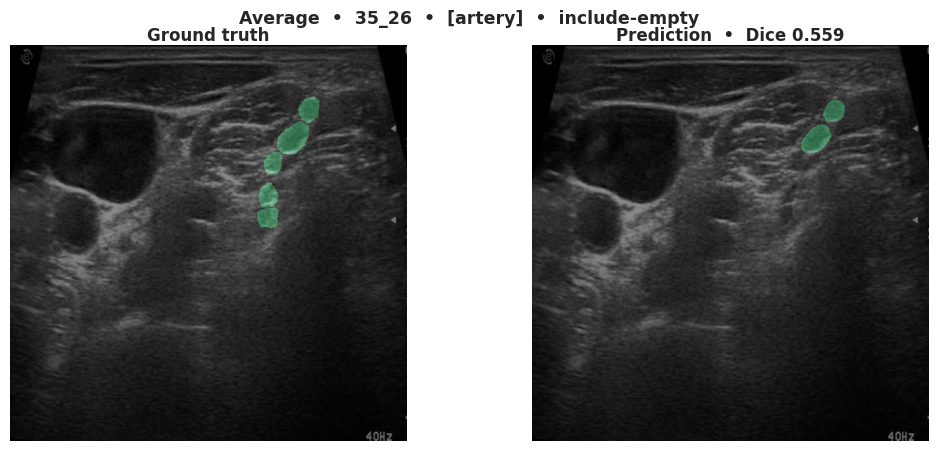

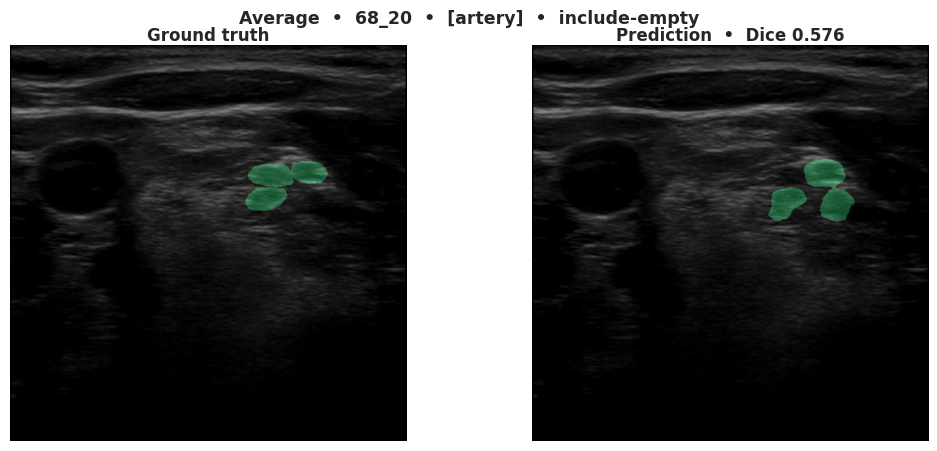

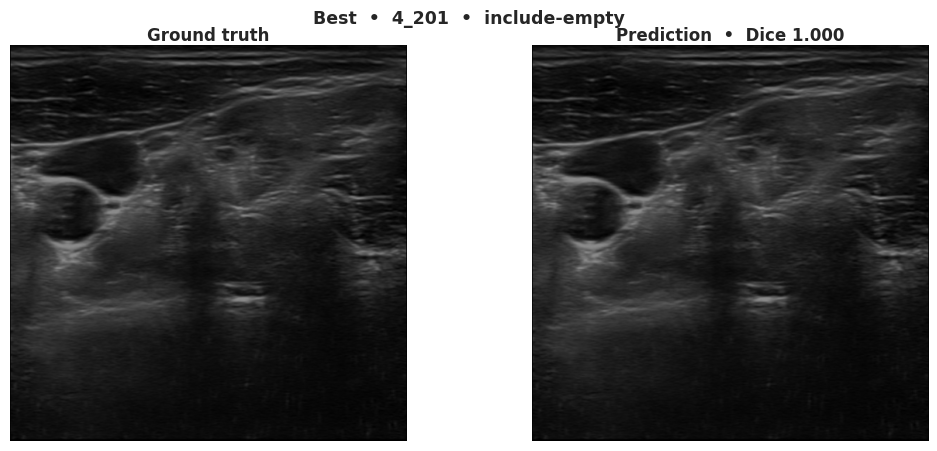

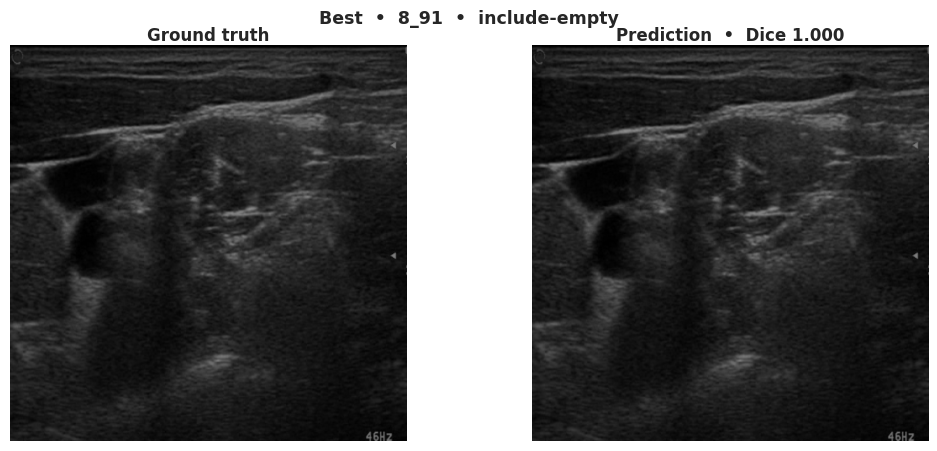

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.



📂 Fold 3/5
  Train patient IDs: [16, 37, 34, 36, 24, 10, 17, 30, 25, 41, 21, 27, 39, 23, 40, 22, 18, 28, 20, 12, 42, 7, 19, 13, 44, 61, 88, 49, 2, 71, 99, 94, 47, 64, 86, 84, 51, 3, 79, 60, 90, 89, 93, 75, 65, 63, 100, 1, 58, 83, 97, 131, 77, 78, 67, 73, 66, 92, 85, 87, 69]
  Val   patient IDs: [43, 29, 15, 14, 38, 31, 48, 82, 166, 52, 76, 53, 5, 6]

Train landmarks stat: 
Nerve  present: 624/662 images

Validation landmarks stat:
Nerve  present: 136/146 images


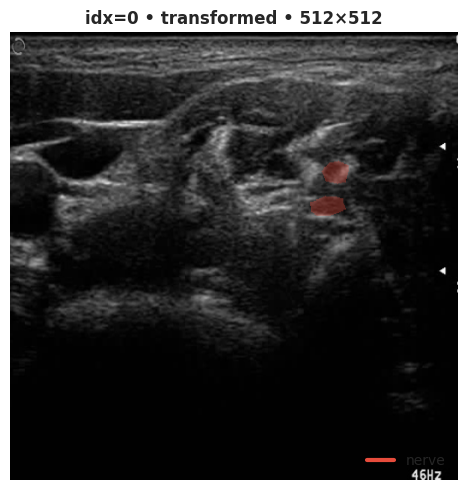

Epoch 001/100 | lr=1.000e-03 train_loss=0.2161 val_loss=0.1865 train_dice=0.0287 val_dice=0.0478 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.1121 val_loss=0.0900 train_dice=0.0521 val_dice=0.0625 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.0834 val_loss=0.0915 train_dice=0.0566 val_dice=0.0803  (patience 1/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.0658 val_loss=0.0698 train_dice=0.1512 val_dice=0.0907 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.0532 val_loss=0.0579 train_dice=0.2889 val_dice=0.1478 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.0448 val_loss=0.0477 train_dice=0.3693 val_dice=0.1599 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.0392 val_loss=0.0453 train_dice=0.4213 val_dice=0.1162 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.0341 val_loss=0.0458 train_dice=0.4503 val_dice=0.1124  (patience 1/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.0300 val_l

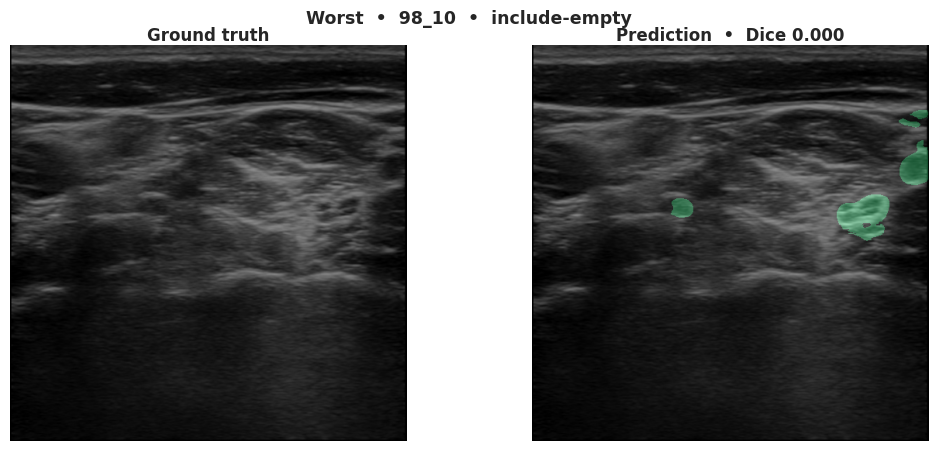

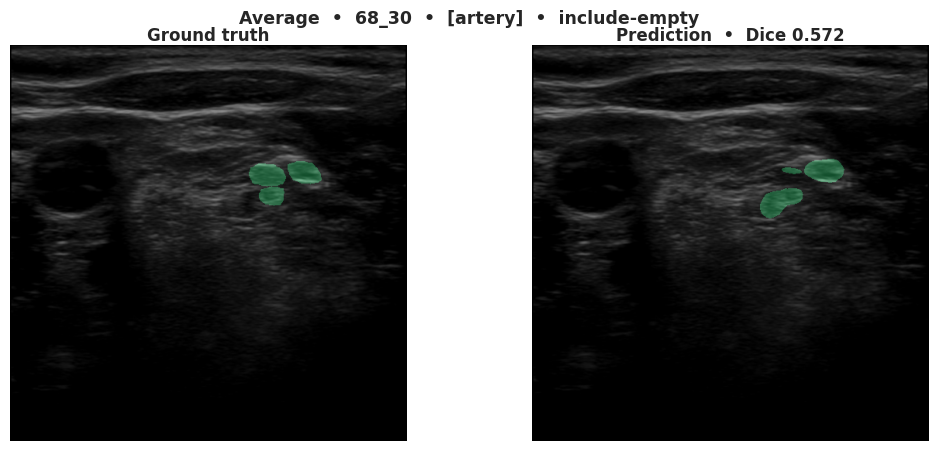

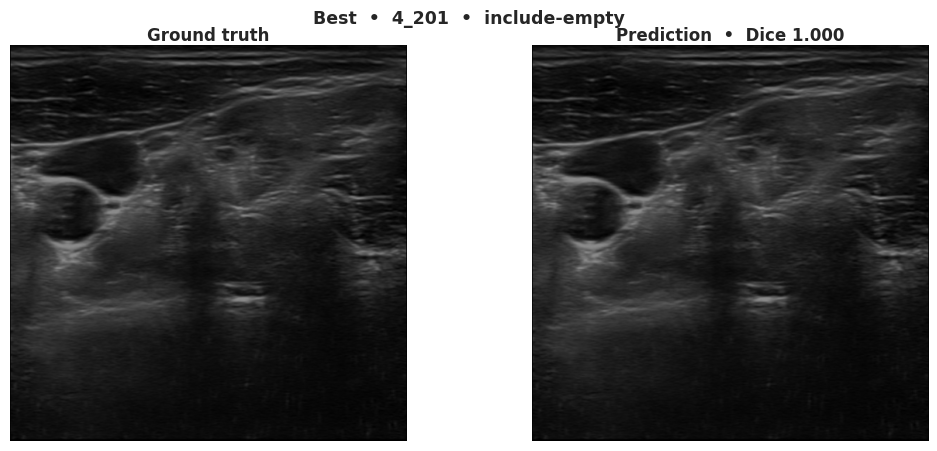

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: ERROR The nbformat package was not found. It is required to save notebook history.



📂 Fold 4/5
  Train patient IDs: [16, 37, 34, 36, 24, 10, 17, 30, 25, 41, 21, 27, 43, 29, 15, 14, 38, 31, 20, 12, 42, 7, 19, 13, 44, 61, 88, 49, 2, 71, 99, 94, 47, 64, 86, 84, 51, 3, 79, 60, 90, 48, 82, 166, 52, 76, 53, 5, 6, 83, 97, 131, 77, 78, 67, 73, 66, 92, 85, 87, 69]
  Val   patient IDs: [39, 23, 40, 22, 18, 28, 89, 93, 75, 65, 63, 100, 1, 58]

Train landmarks stat: 
Nerve  present: 611/653 images

Validation landmarks stat:
Nerve  present: 149/155 images


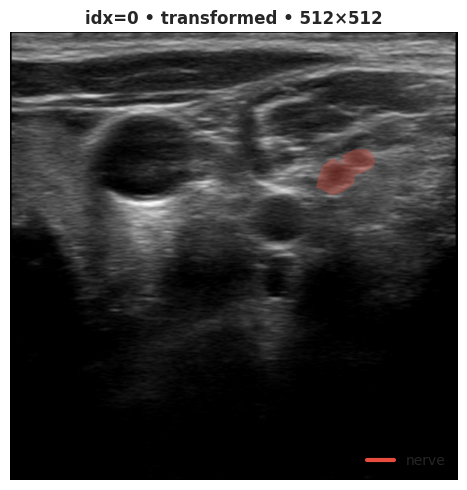

Epoch 001/100 | lr=1.000e-03 train_loss=0.3542 val_loss=0.2313 train_dice=0.0281 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.1947 val_loss=0.1621 train_dice=0.0473 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.1365 val_loss=0.1364 train_dice=0.0510 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.1029 val_loss=0.0866 train_dice=0.0616 val_dice=0.0375 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.0821 val_loss=0.0785 train_dice=0.0770 val_dice=0.0378 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.0687 val_loss=0.0644 train_dice=0.1536 val_dice=0.0545 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.0573 val_loss=0.0547 train_dice=0.2425 val_dice=0.3171 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.0489 val_loss=0.0667 train_dice=0.3415 val_dice=0.3348  (patience 1/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.0418

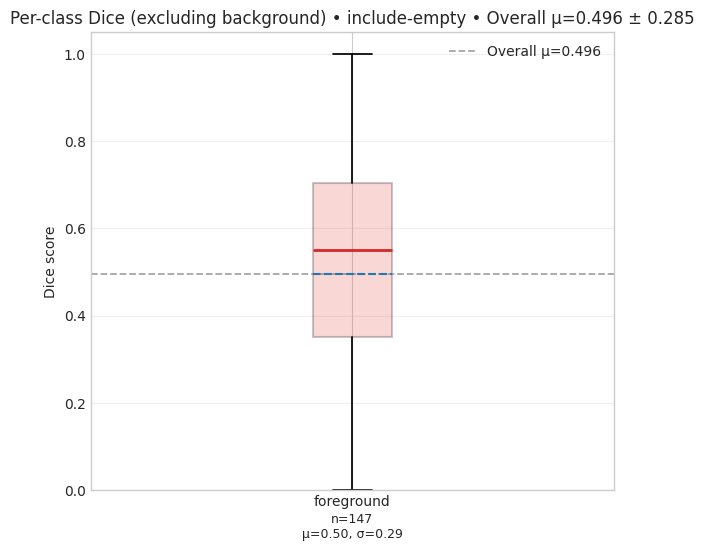

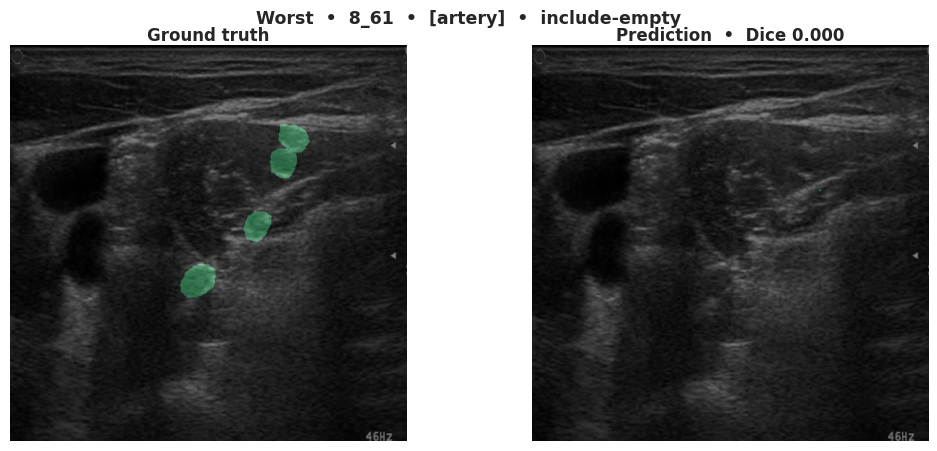

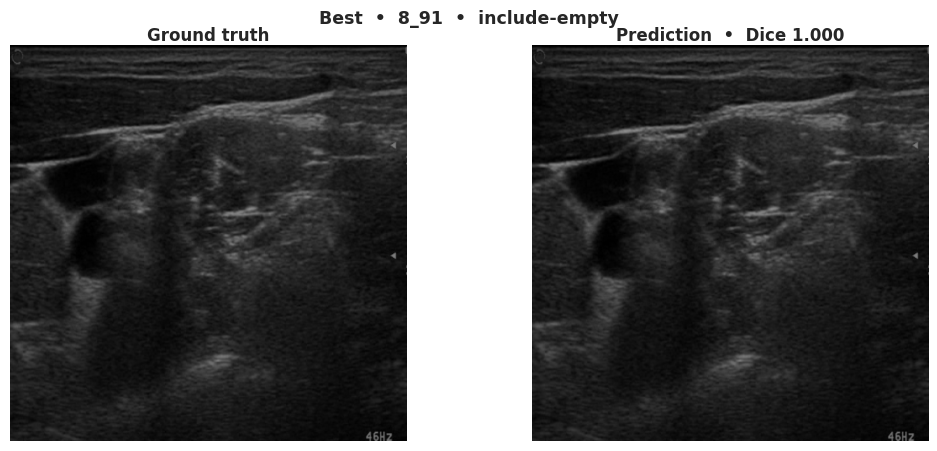

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.



📂 Fold 5/5
  Train patient IDs: [16, 37, 34, 36, 24, 10, 17, 30, 25, 41, 21, 27, 43, 29, 15, 14, 38, 31, 39, 23, 40, 22, 18, 28, 61, 88, 49, 2, 71, 99, 94, 47, 64, 86, 84, 51, 3, 79, 60, 90, 48, 82, 166, 52, 76, 53, 5, 6, 89, 93, 75, 65, 63, 100, 1, 58]
  Val   patient IDs: [20, 12, 42, 7, 19, 13, 44, 83, 97, 131, 77, 78, 67, 73, 66, 92, 85, 87, 69]

Train landmarks stat: 
Nerve  present: 567/609 images

Validation landmarks stat:
Nerve  present: 193/199 images


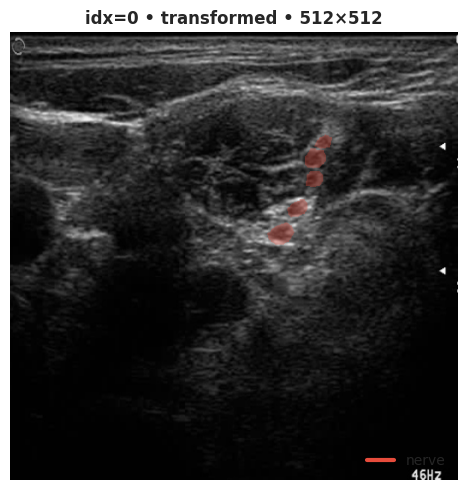

Epoch 001/100 | lr=1.000e-03 train_loss=0.2572 val_loss=0.1608 train_dice=0.0209 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.1231 val_loss=0.1134 train_dice=0.0417 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.0921 val_loss=0.0944 train_dice=0.0529 val_dice=0.0288 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.0784 val_loss=0.1143 train_dice=0.0593 val_dice=0.0000  (patience 1/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.0674 val_loss=0.0870 train_dice=0.0609 val_dice=0.0288 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.0608 val_loss=0.0702 train_dice=0.0577 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.0523 val_loss=0.0664 train_dice=0.0897 val_dice=0.0177 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.0470 val_loss=0.0633 train_dice=0.1690 val_dice=0.2970 [BEST] (patience 0/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.0420

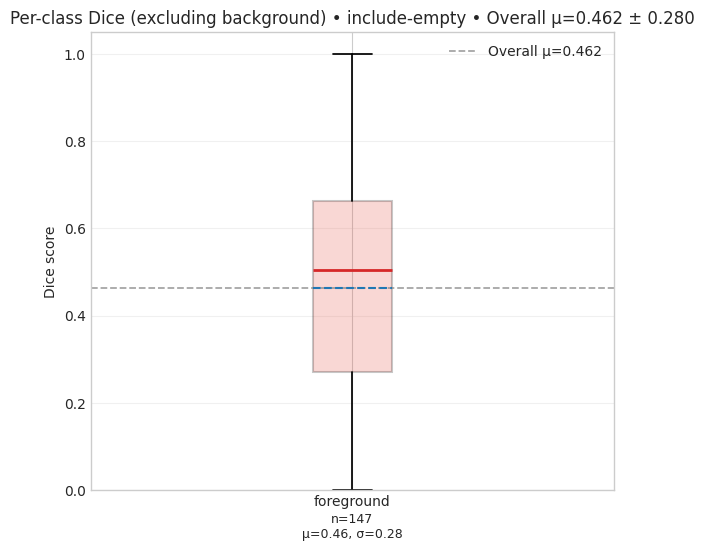

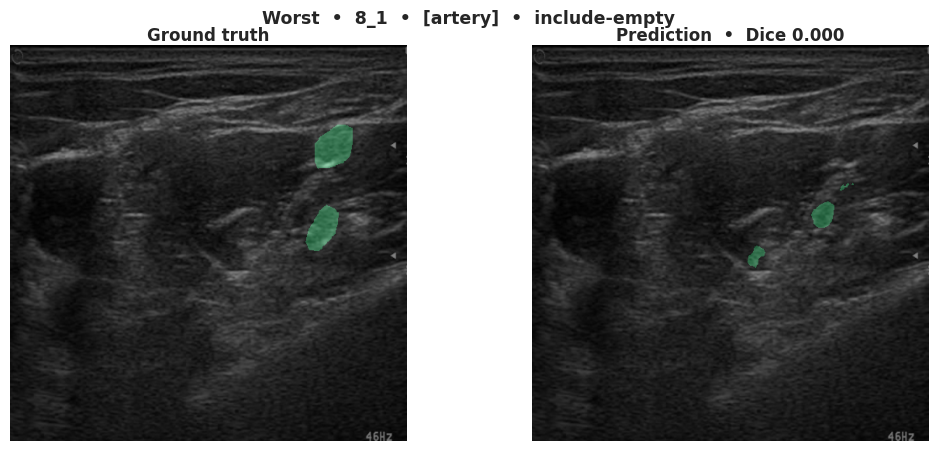

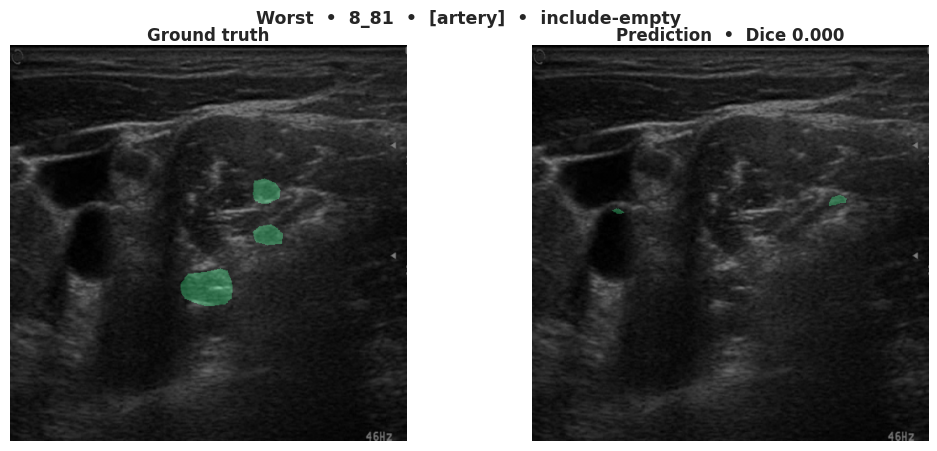

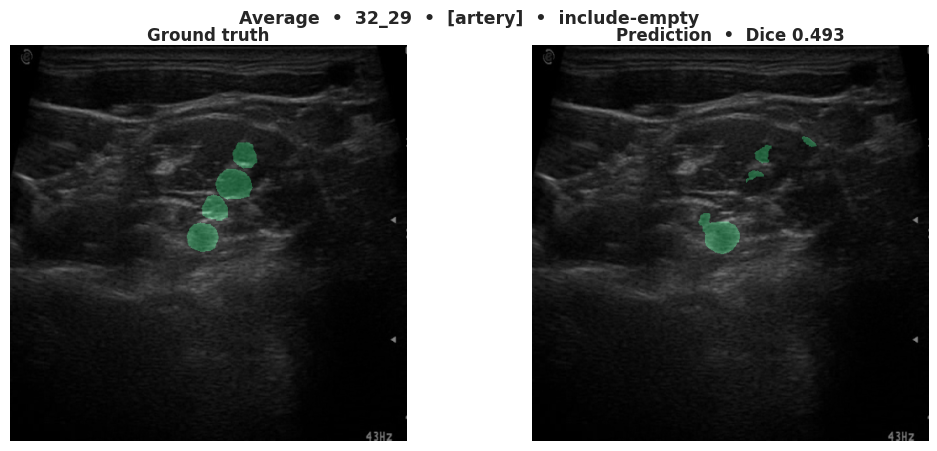

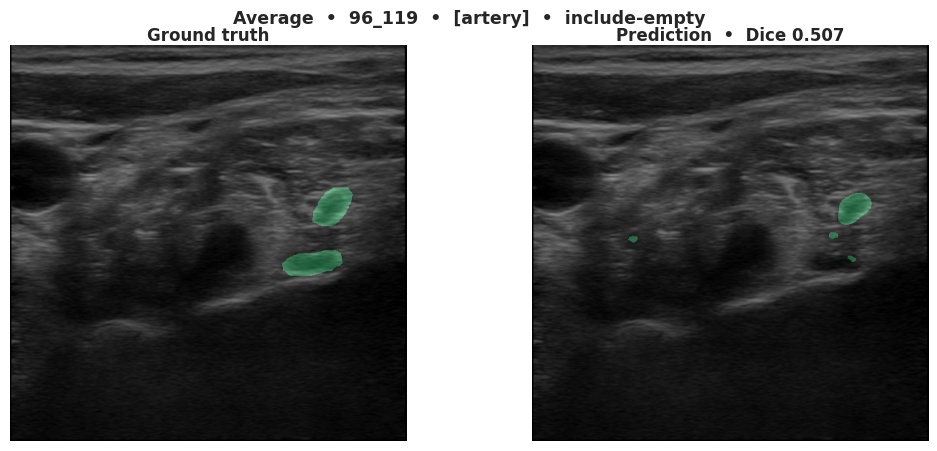

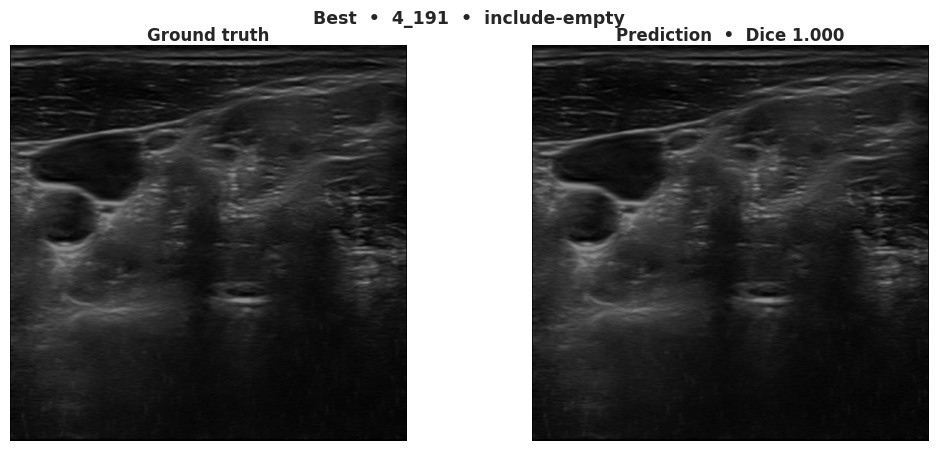

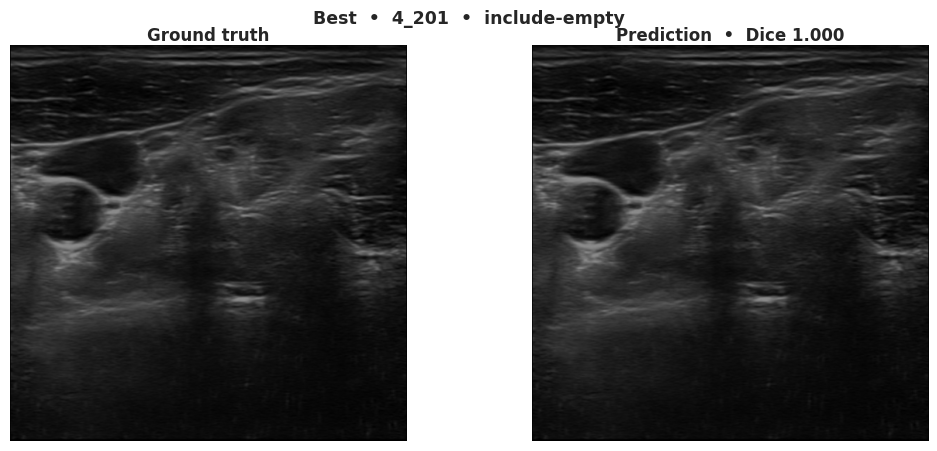

wandb: ERROR The nbformat package was not found. It is required to save notebook history.



🎯 Average overall Dice across folds: 0.4905 ± 0.0179  (n=5)

📌 Per-landmark average Dice across folds:
  1: dongmai (artery)     mean±std: 0.4905 ± 0.0179  (folds=5)

✅ Experiment complete across folds.


In [31]:
res = experiment(variants, exp_id=909999, seed=seed)

In [26]:
res["fold_overall_means"]

[0.4165973663330078,
 0.4482839107513428,
 0.39891743659973145,
 0.44613227248191833,
 0.4510856568813324]